In [1]:
import time
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

In [2]:
# First, we set up the definitions for the power series of our activation functions.
def half_maclaurin(n):
    for i in range(n + 1):
        if i == 1:
            yield 0.5
        else:
            yield 0.0

def sine_maclaurin(n):
    fact = 1.0
    for i in range(n + 1):
        if i > 0:
            fact = fact / i
        
        if i % 2 == 0:
            yield 0.0
        else:
            yield (-1)**(i // 2) * fact

functions = [
    (np.sin, sine_maclaurin, "Sine"),
    (lambda x: 0.5 * x, half_maclaurin, "Half")
]

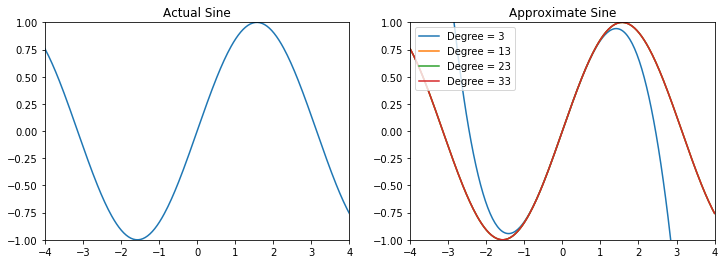

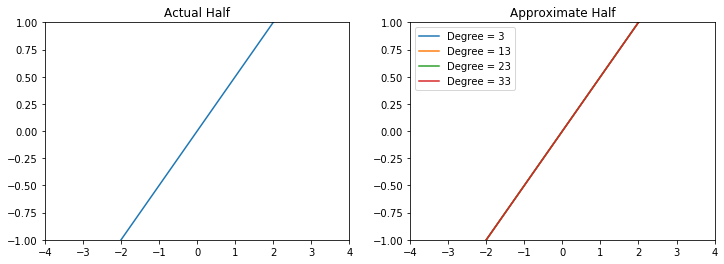

In [3]:
# Second, we check that the power series expansions are correct by simply plotting actual versus approximate.
degrees = [3, 13, 23, 33]

for fn, gfn, name in functions:
    x = np.linspace(-4.0, 4.0, 256)
    y = fn(x)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(x, y)
    axes[0].set_xlim(-4.0, 4.0)
    axes[0].set_ylim(-1.0, 1.0)
    axes[0].set_title(f"Actual {name}")

    for d in degrees:
        coeffs = list(gfn(d))
        z = np.zeros_like(x)

        for n, c in enumerate(coeffs):
            z = z + (c * np.power(x, n))

        axes[1].plot(x, z, label=f"Degree = {d}")
    axes[1].set_xlim(-4.0, 4.0)
    axes[1].set_ylim(-1.0, 1.0)
    axes[1].set_title(f"Approximate {name}")
    axes[1].legend()
    
    plt.show()

In [4]:
# Third, we check the errors in the scalar case.
# Note: s_n is n-th coefficient in power series of function.
#       a_n is n-th coefficient in power series of variable.
# The following solves for the new coefficients in a power series transformation.
def solve_icoeff(s, a, i):
    """Solve for the i-th coefficient in the new power series of $s(x)$.
    Arguments:
    s -- coefficients of power series of function.
    a -- coefficients of power series of variable.
    i -- the index of the coefficient to obtain.
    """
    
    def index_constraint(k_array, k):
        sum_k = 0
        for k_val in k_array:
            sum_k += k_val
            
        return k == sum_k
    
    def power_constraint(k_array, k):
        sum_k = 0
        for j, k_val in enumerate(k_array):
            sum_k += j * k_val
            
        return k == sum_k
    
    def candidate_ks(k_array, k):
        if len(k_array) == 1:
            k_array[0] = k
            yield k_array
        else:
            for j in range(0, k + 1):
                k_array[0] = j
                for solns in candidate_ks(k_array[1:], k - j):
                    yield k_array
    
    def multinomial(k_array):
        if len(k_array) == 1:
            return 1
        return sp.special.binom(sum(k_array), k_array[-1]) * multinomial(k_array[:-1])
    
    coeff = 0.0
    k_array = np.zeros(len(a), dtype=int)
    
    for k in range(len(s)):
        for k_soln in candidate_ks(k_array, k):
            # Check if constraints are satisfied.
            # Then, add the appropriate term.
            if (power_constraint(k_soln, i)):
                prod = 1.0
                for d in range(len(a)):
                    prod *= np.power(a[d], k_soln[d])
                coeff += s[k] * multinomial(k_soln) * prod
                    
    return coeff

In [45]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

func_degrees = [1, 3, 5, 9, 11]
var_degrees = [5, 7, 9, 11]
depths = [1, 2, 3]

runtimes = []

for fn, gfn, name in functions:
    print(f"{'-'*8}{name}{'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
        s = np.array(list(gfn(func_d)))
        
        for var_d in var_degrees:
            # Intialize approximation.
            y = x
            b = np.zeros(var_d + 1)
            b[1] = 1.0

            for depth in depths:
                # Calculate actual function approximation.
                y = fn(y)

                # Perform the transformation.
                c = np.zeros_like(b)
                start = time.time()
                for i in range(var_d + 1):
                    c[i] = solve_icoeff(s, b, i)
                end = time.time()
                b = c
                elapsed = end - start

                # Get the power series estimation.
                z = np.zeros_like(x)
                for i in range(var_d + 1):
                    z = z + (b[i] * np.power(x, i))

                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))

                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
            

--------Sine--------
N=1,	 D=5,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00122833
N=1,	 D=5,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00061584
N=1,	 D=5,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00065088
N=1,	 D=7,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00111628
N=1,	 D=7,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00111723
N=1,	 D=7,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00111508
N=1,	 D=9,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00186896
N=1,	 D=9,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00202465
N=1,	 D=9,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00192904
N=1,	 D=11,	 Depth=1:	 Error=   6.225994027889,	 Time=0.00290060
N=1,	 D=11,	 Depth=2:	 Error=   6.252568935435,	 Time=0.00295186
N=1,	 D=11,	 Depth=3:	 Error=   6.271928629772,	 Time=0.00288677
N=3,	 D=5,	 Depth=1:	 Error=   5.339799899957,	 Time=0.00427461
N=3,	 D=5,	 Depth=2:	 Error=  56.406293040447,	 Time=0.00424170
N=3,	 D=5,	 Depth=3:	 Error= 190.912504714616,	 Time=0.00473046
N=3,	 D=7,	 Dept

--------Sine--------


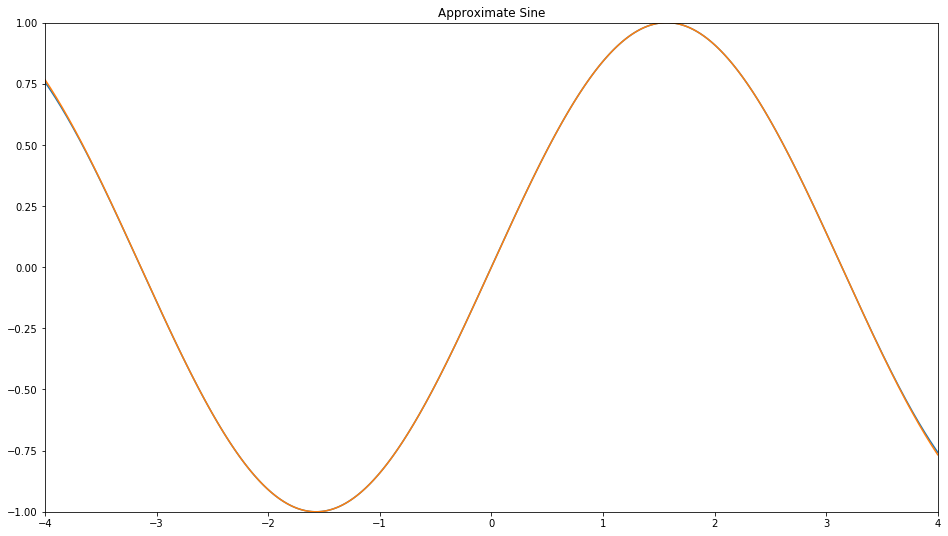

N=11,	 D=11,	 Depth=1:	 Error=   0.005481067673,	 Time=138.20358610


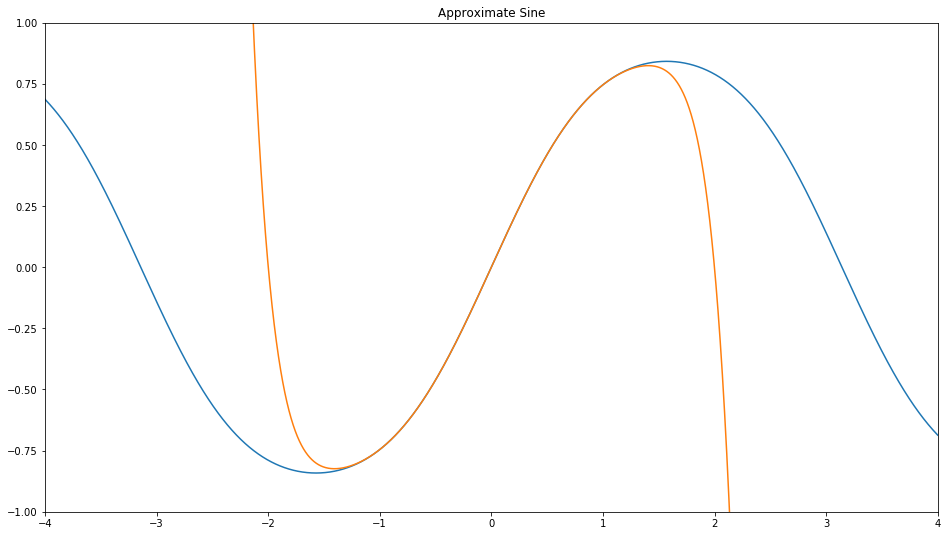

N=11,	 D=11,	 Depth=2:	 Error=1689.531562288227,	 Time=142.87951684


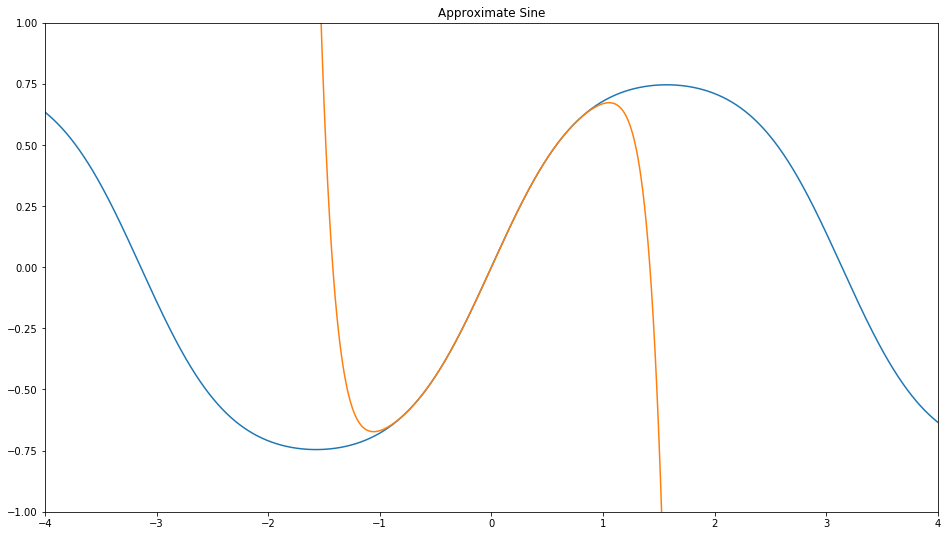

N=11,	 D=11,	 Depth=3:	 Error=70804.257799620187,	 Time=143.51270199
--------Half--------


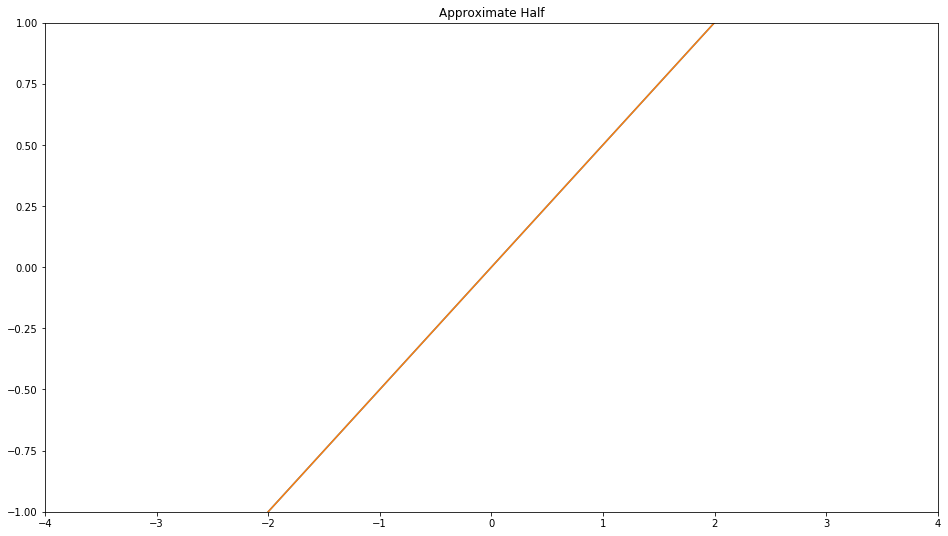

N=11,	 D=11,	 Depth=1:	 Error=   0.000000000000,	 Time=149.37458897


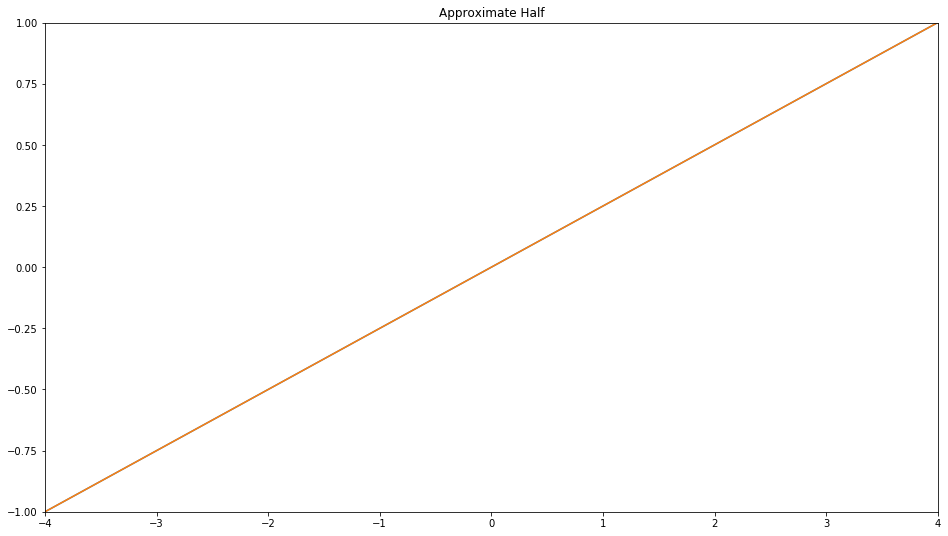

N=11,	 D=11,	 Depth=2:	 Error=   0.000000000000,	 Time=147.01839495


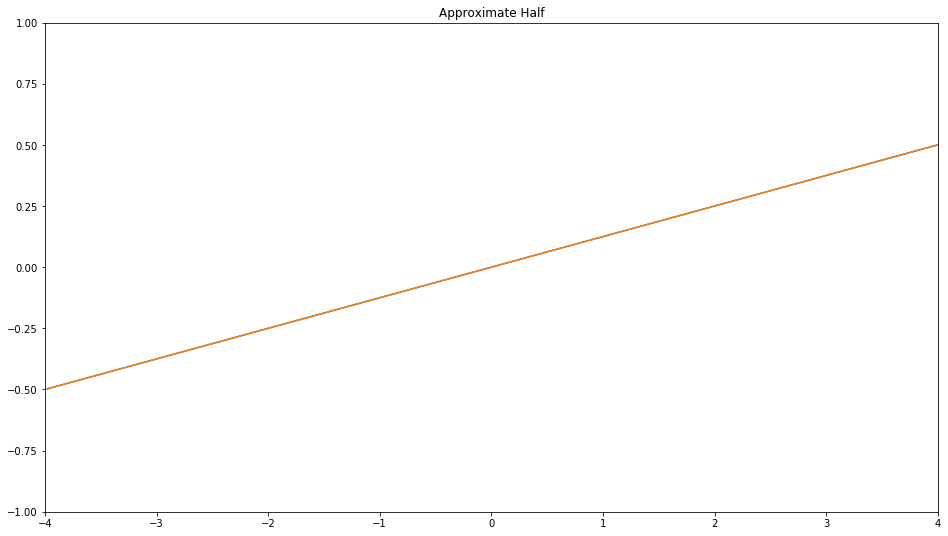

N=11,	 D=11,	 Depth=3:	 Error=   0.000000000000,	 Time=142.94736266


In [5]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

# func_degrees = [1, 3, 5, 9, 11]
# var_degrees = [5, 7, 9, 11]
# depths = [1, 2, 3]

func_degrees = [11]
var_degrees = [11]
depths = [1, 2, 3]

runtimes = []

for fn, gfn, name in functions:
    print(f"{'-'*8}{name}{'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
        s = np.array(list(gfn(func_d)))
        
        for var_d in var_degrees:
            # Intialize approximation.
            y = x
            b = np.zeros(var_d + 1)
            b[1] = 1.0

            for depth in depths:
                # Calculate actual function approximation.
                y = fn(y)

                # Perform the transformation.
                c = np.zeros_like(b)
                start = time.time()
                for i in range(var_d + 1):
                    c[i] = solve_icoeff(s, b, i)
                end = time.time()
                b = c
                elapsed = end - start

                # Get the power series estimation.
                z = np.zeros_like(x)
                for i in range(var_d + 1):
                    z = z + (b[i] * np.power(x, i))

                fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
                    
                axes.plot(x, y)
                axes.set_xlim(-4.0, 4.0)
                axes.set_ylim(-1.0, 1.0)
                axes.set_title(f"Actual {name}")

                axes.plot(x, z)
                axes.set_xlim(-4.0, 4.0)
                axes.set_ylim(-1.0, 1.0)
                axes.set_title(f"Approximate {name}")
                
                plt.show()
                    
                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))

                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
            